# Сеть с фильтром Собеля

- Устанавливаем TVM:

In [1]:
!pip install --pre apache-tvm~=0.11

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 MB 10.7 MB/s eta 0:00:0000:0100:01


- Установим необходимые библиотеки:

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import urllib
import tvm
from tvm import relay
from tvm.contrib import graph_executor
from keras.models import Sequential
from keras.layers import Conv2D

# За образец возьмем оператор Собеля из библиотеки OpenCV

In [3]:
# изображение для фильтрации
img_path = 'https://drive.google.com/uc?id=1tfxkNRiced6dNm-hWfENl4jWGCyOHges'

In [4]:
# читаем изображение
req = urllib.request.urlopen(img_path)
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
image_src = cv.imdecode(arr, -1)

# конвертируем в ч/б изображение
image_src = cv.cvtColor(image_src, cv.COLOR_BGR2GRAY)

# добавляем небольшое размытие для сглаживания
image_src = cv.GaussianBlur(image_src, (3, 3), 0)

# размеры изображения, количество каналов
img_h = image_src.shape[0]
img_w = image_src.shape[1]
img_n_channels = 1

image_src.shape

(319, 480)

In [5]:
scale = 1
delta = 0
ddepth = cv.CV_16S

image_sobel_x = cv.Sobel(image_src, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv.BORDER_DEFAULT)

image_sobel = cv.convertScaleAbs(image_sobel_x)

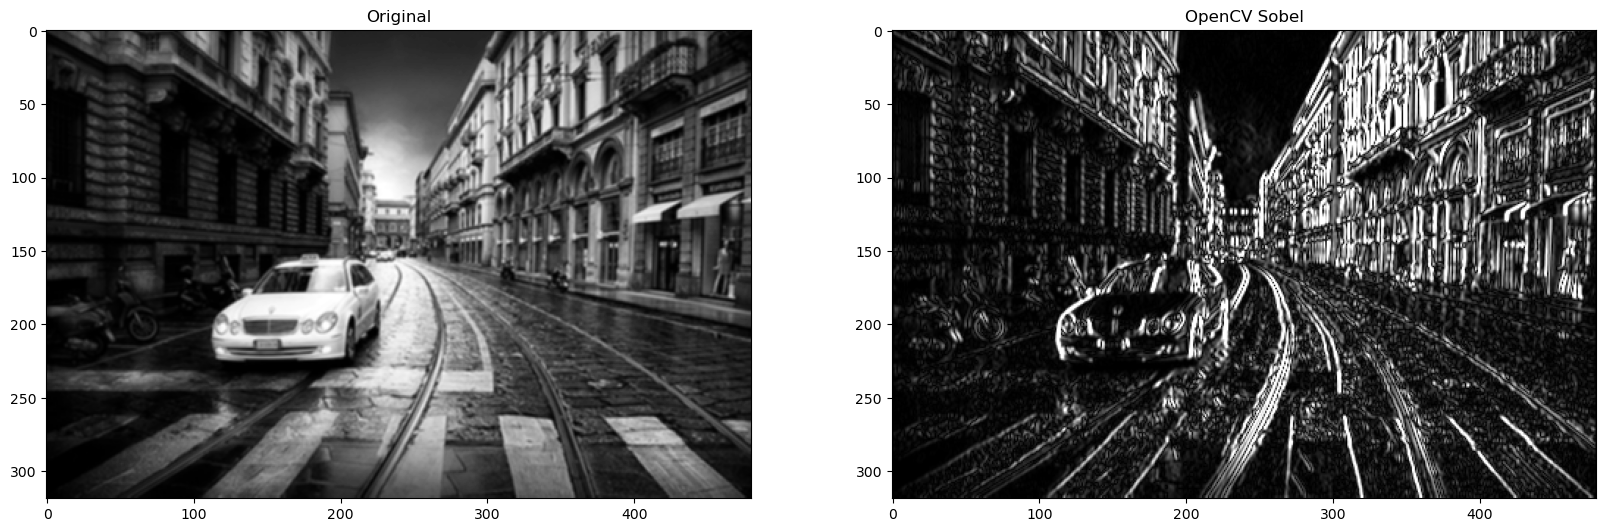

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
for ax, im, title in zip(axes, [image_src, image_sobel], ['Original', 'OpenCV Sobel']):
    ax.set_title(title)
    ax.imshow(im, cmap='gray');

## Модель, реализующая фильтр Собеля на Keras

In [7]:
Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
Ky = Kx.T
K = Ky
K_weights = K.reshape(1, 3, 3, 1, 1)

In [56]:
model_keras = Sequential()
model_keras.add(Conv2D(1, kernel_size=3, input_shape=(img_h, img_w, img_n_channels), activation='relu', padding="same", use_bias=False, weights=K_weights, name='sobel'))

In [57]:
image = image_src.reshape(1, img_h, img_w, 1) / 255
image_f = model_keras.predict(image)
image_filtered = (image_f.reshape(img_h, img_w)) * 255

1/1 [==============================] - 0s 55ms/step


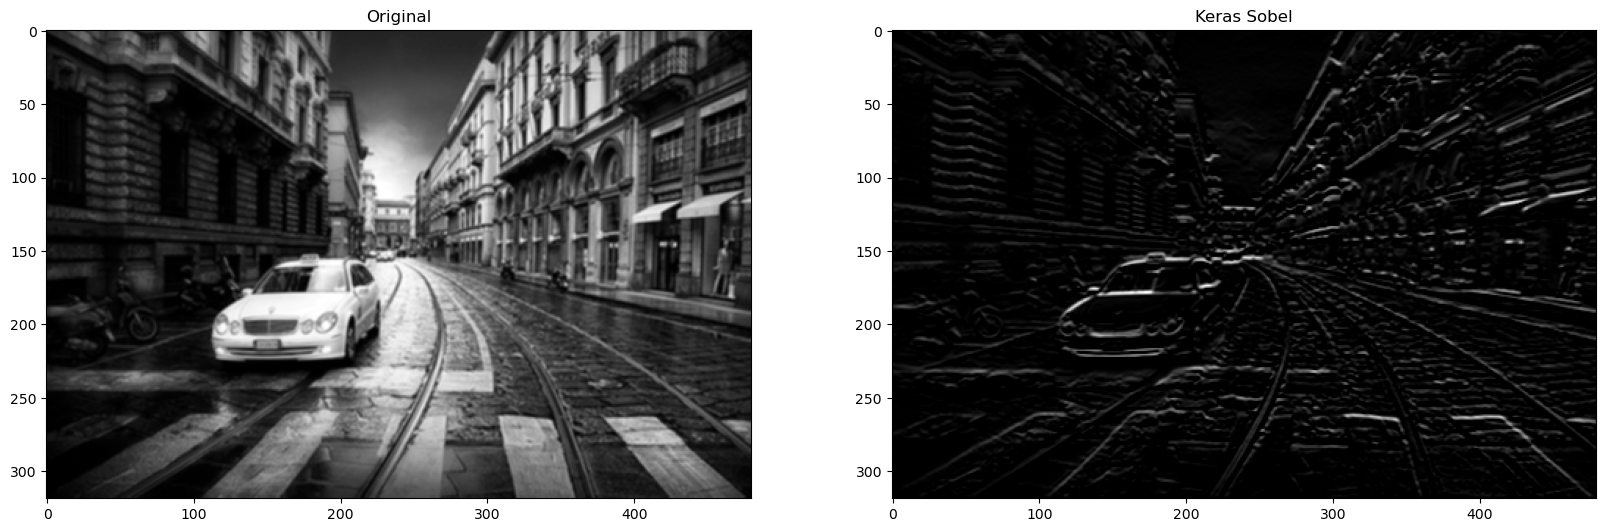

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
for ax, im, title in zip(axes, [image_src, image_filtered], ['Original', 'Keras Sobel']):
    ax.set_title(title)
    ax.imshow(im, cmap='gray');

In [59]:
model_keras.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model_keras.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sobel (Conv2D)              (None, 319, 480, 1)       9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


# Загружаем модель из Keras в TVM:

In [60]:
input_shape = [1, img_h, img_w, img_n_channels] # [batch, height, width, channels]
shape_dict = {"sobel_input": input_shape}
mod = tvm.IRModule()
mod, params = relay.frontend.from_keras(model_keras, shape_dict, layout="NHWC")
print(mod)

def @main(%sobel_input: Tensor[(1, 319, 480, 1), float32], %v_param_1: Tensor[(3, 3, 1, 1), float32]) {
  %0 = nn.conv2d(%sobel_input, %v_param_1, padding=[1i64, 1i64, 1i64, 1i64], channels=1, kernel_size=[3, 3], data_layout="NHWC", kernel_layout="HWIO");
  nn.relu(%0)
}



- Указываем устройство, для которого модель должна быть скомпилирована и устройство, на котором модель будет запущена:

In [61]:
target = tvm.target.Target("llvm")
dev = tvm.cpu(0)

- Строим модель и создаём для неё `GraphExecutor`:

In [62]:
with tvm.transform.PassContext(opt_level=3):
    model_tvm = relay.build_module.create_executor("graph", mod, dev, target, params).evaluate()

# Настройка (тюнинг) модели в TVM

## Установка необходимых зависимостей

- Установим модули Python, которые могут потребоваться во время настройки моделей в TVM.

In [15]:
# If you are using Mac OSX, you should first install OpenMP library (libomp)
!pip3 install --user tornado psutil 'xgboost<1.6.0' cloudpickle

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.6/173.6 MB 4.7 MB/s eta 0:00:0000:0100:01


## Некоторые общие функции и переменные

- Объявим некоторые общие переменные, которые будут использоваться во всех режимах тюнинга:

In [41]:
model_name = "my_model"
input_name = "sobel_input"
target = tvm.target.Target("llvm")

import multiprocessing
import os
# Set number of threads used for tuning based on the number of
# physical CPU cores on your machine.
num_threads = multiprocessing.cpu_count()
print("Num threads: ", int(num_threads/2))
os.environ["TVM_NUM_THREADS"] = str(int(num_threads/2))

Num threads:  2


- Следующая функция будет использоваться для оценки времени работы модели:

In [42]:
def evaluate_performance(lib, data_shape, dtype="float32"):
    # upload parameters to device
    dev = tvm.cpu()
    data_tvm = tvm.nd.array((np.random.uniform(size=data_shape)).astype(dtype))
    module = graph_executor.GraphModule(lib["default"](dev))
    module.set_input(input_name, data_tvm)

    # evaluate
    print("Evaluate inference time cost...")
    print(module.benchmark(dev, number=100, repeat=3))

## AutoTVM

- Подключаем необходимые модули:

In [18]:
from tvm import autotvm
from tvm.autotvm.tuner import XGBTuner, GATuner, RandomTuner, GridSearchTuner

In [19]:
log_file = "/content/tvm/%s.autotvm.log" % model_name

- Определим функцию, которая будет отвечать за извлечение задач из модели:

In [65]:
# extract workloads from relay program
def extract_tasks(mod, target, params):
    print("Mod:")
    print(mod)
    print("Extract tasks...")
    tasks = autotvm.task.extract_from_program(
        mod, target=target, params=params
    )
    #assert(len(tasks) > 0)
    if len(tasks) > 0:
      for idx, task in enumerate(tasks):
          print("Task: %d,  workload: %s" % (idx, task.workload))
      return tasks
    else:
      print("No tasks to optimizing")
      return False

- Извлечем задачи:

In [66]:
tasks = extract_tasks(mod, target, params)

Mod:
def @main(%sobel_input: Tensor[(1, 319, 480, 1), float32]) {
  %0 = nn.conv2d(%sobel_input, meta[relay.Constant][0], padding=[1i64, 1i64, 1i64, 1i64], channels=1, kernel_size=[3, 3], data_layout="NHWC", kernel_layout="HWIO");
  nn.relu(%0)
}


Extract tasks...
No tasks to optimizing


Задач для оптимизации не было найдено, т.к. модель состоит из свёрточного слоя conv2d, который не оптимизируется AutoTVM для x86.

## Auto-Scheduler

- Подключаем необходимые модули:

In [22]:
from tvm import auto_scheduler

- Устанавливаем значение переменной `log_file`:

In [23]:
log_file = "/content/tvm/%s.auto-scheduler.log" % model_name

- Определим функцию, которая будет отвечать за извлечение задач из модели:

In [24]:
# extract workloads from relay program
def extract_tasks(mod, target, params):
    print("Mod:")
    print(mod)
    print("Extract tasks...")
    tasks, task_weights = auto_scheduler.extract_tasks(mod, params, target)
    assert(len(tasks) > 0)

    for idx, task in enumerate(tasks):
        print("Task: %d, desc: %s" % (idx, task.desc))
    return tasks, task_weights

- Извлечем задачи:

In [25]:
tasks, task_weights = extract_tasks(mod, target, params)

Mod:
def @main(%sobel_input: Tensor[(1, 319, 480, 1), float32]) {
  %0 = nn.conv2d(%sobel_input, meta[relay.Constant][0], padding=[1i64, 1i64, 1i64, 1i64], channels=1, kernel_size=[3, 3], data_layout="NHWC", kernel_layout="HWIO");
  nn.relu(%0)
}


Extract tasks...
Task: 0, desc: vm_mod_fused_nn_conv2d_nn_relu


- Определим функцию, которая будет запускать настройку модели:

In [43]:
def run_tuning(tasks, task_weights, log_file, n_trials):
    print("Begin tuning...")
    tuner = auto_scheduler.TaskScheduler(tasks, task_weights)
    tune_option = auto_scheduler.TuningOptions(
        num_measure_trials=n_trials,  # change this to 20000 to achieve the best performance
        runner=auto_scheduler.LocalRunner(repeat=2, enable_cpu_cache_flush=True),
        measure_callbacks=[auto_scheduler.RecordToFile(log_file)],
    )

    tuner.tune(tune_option)

- Запускаем тюнинг:

In [44]:
run_tuning(tasks, task_weights, log_file,  128)

Begin tuning...
----------------------------------------------------------------------
------------------------------  [ Task Scheduler ]
----------------------------------------------------------------------
|  ID  |                       Task Description                        | Latency (ms) | Speed (GFLOPS) | Trials |
-----------------------------------------------------------------------------------------------------------------
|    0 |                                vm_mod_fused_nn_conv2d_nn_relu |            - |              - |      0 |
-----------------------------------------------------------------------------------------------------------------
Estimated total latency: - ms	Trials: 0	Used time : 0 s	Next ID: 0	
----------------------------------------------------------------------
------------------------------  [ Search ]
----------------------------------------------------------------------
Generate Sketches		#s: 3
Sample Initial Population	#s: 1747	fail_ct: 1	Time elapse

- Модифицируем функцию для оценки эффективности настройки модели:

In [45]:
def evaluate(module, data_shape, log_file, target="llvm"):
    # compile kernels in default mode
    print("Evaluation of the network compiled in 'default' mode without auto tune:")
    with tvm.transform.PassContext(opt_level=3):
        print("Compile...")
        lib = relay.build(module, target=target, params=params)
        evaluate_performance(lib, data_shape)

    # compile kernels in kernel tuned only mode
    print("\nEvaluation of the network been tuned on kernel level:")
    with auto_scheduler.ApplyHistoryBest(log_file):
        print("Compile...")
        with tvm.transform.PassContext(opt_level=3, config={"relay.backend.use_auto_scheduler": True}):
            lib = relay.build(module, target=target, params=params)
        evaluate_performance(lib, data_shape)

- Запустим функцию и оценим полученную производительность:

In [46]:
evaluate(mod, input_shape, log_file, target)

Evaluation of the network compiled in 'default' mode without auto tune:
Compile...
Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
   1.2873       1.2828       1.2975       1.2816       0.0072   
               

Evaluation of the network been tuned on kernel level:
Compile...
Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
   0.1648       0.1638       0.1674       0.1633       0.0018   
               


Как можно видеть, Auto-Scheduler дал уже довольно значительный прирост производительности в сравнении с расписанием "по умолчанию". Такое ускорение в сравнении с AutoTVM объясняется тем, что для Auto-Scheduler не нужно расписание, написанное полльзователем, и он сам на основе различных оптимизаций автоматически ускорил свёрточные слои в нашей модели.

## Meta-Scheduler (TensorIR)

- Подключаем необходимые модули:

In [47]:
from tvm import meta_schedule as ms

- Объявляем некоторые Meta-Schedule специфичные переменные:

In [48]:
strategy_name = "evolutionary"
work_dir = "/content/tvm/{}_meta-scheduler_{}".format(model_name, strategy_name)
target = tvm.target.Target("llvm -mcpu=core-avx2 -num-cores {}".format(int(num_threads/2)))

- Определим функцию, которая будет отвечать за извлечение задач из модели:

In [49]:
# extract workloads from relay program
def extract_tasks(mod, target, params, strategy):
    print("Mod:")
    print(mod)
    print("Extract tasks...")
    extracted_tasks = ms.relay_integration.extract_tasks(
        mod, target, params
    )
    assert(len(extracted_tasks) > 0)
    
    tasks, task_weights = ms.relay_integration.extracted_tasks_to_tune_contexts(
        extracted_tasks, work_dir, strategy=strategy
    )

    for idx, task in enumerate(tasks):
        print("Task: %d, desc: %s" % (idx, task.task_name))

    return tasks, task_weights

- Извлечем задачи:

In [50]:
tasks, task_weights = extract_tasks(mod, target, params, strategy_name)

Mod:
def @main(%sobel_input: Tensor[(1, 319, 480, 1), float32], %v_param_1: Tensor[(3, 3, 1, 1), float32]) {
  %0 = nn.conv2d(%sobel_input, %v_param_1, padding=[1i64, 1i64, 1i64, 1i64], channels=1, kernel_size=[3, 3], data_layout="NHWC", kernel_layout="HWIO");
  nn.relu(%0)
}

Extract tasks...
2023-02-16 08:43:21 [INFO] Logging directory: /content/tvm/my_model_meta-scheduler_evolutionary/logs
Task: 0, desc: fused_nn_conv2d_nn_relu


- Определим функцию, которая будет запускать настройку модели:

In [51]:
import os

def run_tuning(tasks, task_weights, work_dir, n_trials):
    if not os.path.exists(work_dir):
        os.mkdir(work_dir)
    print("Begin tuning...")    
    evaluator_config = ms.runner.config.EvaluatorConfig(number=1, repeat=2, enable_cpu_cache_flush=True);
    database = ms.tune.tune_tasks(
        tasks=tasks,
        task_weights=task_weights,
        work_dir=work_dir,
        max_trials_global=n_trials,
        num_trials_per_iter=64,
        max_trials_per_task=256,
        builder=ms.builder.LocalBuilder(),
        runner=ms.runner.LocalRunner(evaluator_config=evaluator_config),
    )

- Запускаем тюнинг:

In [52]:
run_tuning(tasks, task_weights, work_dir, 128)

2023-02-16 08:48:30 [INFO] [task_scheduler.cc:260] Task #0 has finished. Remaining task(s): 0


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,fused_nn_conv2d_nn_relu,2909280,1,29.1145,99.9253,99.9253,128,Y



Total trials: 128
Total latency (us): 99.9253

2023-02-16 08:48:30 [DEBUG] [task_scheduler.cc:318] 
 ID |                    Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
-------------------------------------------------------------------------------------------------------------------------
  0 | fused_nn_conv2d_nn_relu | 2909280 |      1 |        29.1145 |      99.9253 |               99.9253 |    128 |    Y 
-------------------------------------------------------------------------------------------------------------------------
Total trials: 128
Total latency (us): 99.9253



- Модифицируем функцию для оценки эффективности настройки модели:

In [53]:
def evaluate(module, data_shape, work_dir, target="llvm"):
    # compile kernels in default mode
    print("Evaluation of the network compiled in 'default' mode without auto tune:")
    with tvm.transform.PassContext(opt_level=3):
        print("Compile...")
        lib = relay.build(module, target=target, params=params)
        evaluate_performance(lib, data_shape)

    # compile kernels in kernel tuned only mode
    print("\nEvaluation of the network been tuned on kernel level:")
    print("Compile...")
    database = ms.database.JSONDatabase(f"{work_dir}/database_workload.json",
                                        f"{work_dir}/database_tuning_record.json",
                                        allow_missing=False)
    with tvm.transform.PassContext(opt_level=3):
        lib = ms.relay_integration.compile_relay(database, module, target, params)
        evaluate_performance(lib, data_shape)

- Запустим функцию и оценим полученную производительность:

In [54]:
evaluate(mod, input_shape, work_dir, target)

Evaluation of the network compiled in 'default' mode without auto tune:
Compile...
Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
   0.7182       0.7619       0.7769       0.6158       0.0727   
               

Evaluation of the network been tuned on kernel level:
Compile...
Evaluate inference time cost...
Execution time summary:
 mean (ms)   median (ms)    max (ms)     min (ms)     std (ms)  
   0.0961       0.0957       0.0986       0.0939       0.0019   
               


Результаты, полученные при настройке с Meta-Scheduler, оказались лучше, чем результаты с Auto-Scheduler.

## Модель, реализующая фильтр Собеля на TVM Relay

In [54]:
model_relay = relay.nn.conv2d(
    [img_h, img_w, img_n_channels],
    K_weights,
    padding=(0, 0),
    channels=img_n_channels,
    kernel_size=[3, 3],
    data_layout='NHWC',
    kernel_layout='HWIO'
)
print(relay_model)

TypeError: ignored

In [ ]:
relay_mod = tvm.IRModule({"main": f})
viz = relay_viz.RelayVisualizer(relay_mod)
viz.render()

@main([Var(x)])

`--Call 

   |--add 

   |--Call 

   |  |--log 

   |  `--Var(Input) name_hint: x

   `--Call 

      |--log 

      `--Var(Input) name_hint: x


2. Напишите руками простую сеть на Relay из одного свёрточного слоя, которая будет применять фильтр Собеля для входного чёрно-белого изображения.
    - После запуска настройте модель с помощью всех алгоритмов настройки и сравните производительность.